In [ ]:
# Install newer compatible versions
!pip uninstall -y transformers diffusers
!pip install -q diffusers==0.30.0 transformers==4.44.0 accelerate

# This works with both sentence-transformers and our generator
# Restart runtime

Found existing installation: transformers 4.57.1
Uninstalling transformers-4.57.1:
  Successfully uninstalled transformers-4.57.1
Found existing installation: diffusers 0.35.2
Uninstalling diffusers-0.35.2:
  Successfully uninstalled diffusers-0.35.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 150.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 120.6 MB/s eta 0:00:00


In [ ]:
!pip install -q diffusers transformers accelerate torch pillow streamlit pyngrok
!apt-get install -y fonts-dejavu-core fonts-liberation > /dev/null 2>&1
print("✅ All dependencies installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 130.2 MB/s eta 0:00:00
✅ All dependencies installed!


In [ ]:
import streamlit as st
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import torch
from PIL import Image, ImageDraw, ImageFont
import textwrap
import io
import os

print("✅ Libraries imported successfully!")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"💻 CUDA available: {torch.cuda.is_available()}")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

✅ Libraries imported successfully!
🔥 PyTorch version: 2.8.0+cu126
💻 CUDA available: True


In [ ]:
# Model cache decorator
@st.cache_resource
def load_model():
    """Load Stable Diffusion model once and cache it"""
    MODEL_ID = "runwayml/stable-diffusion-v1-5"  # Fast, lightweight model
    device = "cuda" if torch.cuda.is_available() else "cpu"

    print(f" Loading model on {device}...")

    pipe = StableDiffusionPipeline.from_pretrained(
        MODEL_ID,
        dtype=torch.float16 if device == "cuda" else torch.float32,
        safety_checker=None,
        requires_safety_checker=False
    )

    # Faster scheduler
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
    pipe = pipe.to(device)

    # Memory optimization
    if device == "cuda":
        pipe.enable_attention_slicing()
        print("✅ GPU optimizations enabled")

    print("✅ Model loaded successfully!")
    return pipe, device

def enhance_prompt(prompt, style="vibrant"):
    """Add cinematic style keywords to prompt"""
    styles = {
        "vibrant": "bright colorful cinematic background, dramatic lighting, high saturation, professional photography, 4k, ultra detailed",
        "dark": "dark moody atmosphere, cinematic noir lighting, high contrast, dramatic shadows, 4k, professional",
        "neon": "neon lights, cyberpunk style, vibrant glowing colors, futuristic cityscape, 4k, highly detailed",
        "minimal": "clean minimal background, soft studio lighting, professional product photography, 4k",
        "epic": "epic dramatic scene, volumetric god rays, cinematic wide angle, highly detailed, 4k"
    }
    return f"{prompt}, {styles.get(style, styles['vibrant'])}"

def generate_image(pipe, device, prompt, style, width=512, height=512, steps=28):
    """Generate base thumbnail image"""
    enhanced = enhance_prompt(prompt, style)
    print(f"🎨 Generating: {enhanced[:100]}...")

    if device == "cuda":
        with torch.autocast(device):
            image = pipe(
                enhanced,
                guidance_scale=7.5,
                num_inference_steps=steps,
                width=width,
                height=height
            ).images[0]
    else:
        image = pipe(
            enhanced,
            guidance_scale=7.5,
            num_inference_steps=steps,
            width=width,
            height=height
        ).images[0]

    print("✅ Image generated!")
    return image

def add_caption(
    image,
    text,
    font_size_ratio=0.15,
    text_color=(255, 255, 255),
    outline_color=(0, 0, 0),
    outline_width_ratio=0.015,
    position="bottom",
    box_opacity=0.3
):
    """Add YouTube-style caption to image"""
    img = image.convert("RGBA")
    W, H = img.size

    # Create transparent overlay
    overlay = Image.new('RGBA', img.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)

    # Load bold font
    font_paths = [
        "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf",
        "/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf",
        "/System/Library/Fonts/Helvetica.ttc",
    ]

    font_size = int(H * font_size_ratio)
    font = None

    for path in font_paths:
        if os.path.exists(path):
            try:
                font = ImageFont.truetype(path, font_size)
                break
            except:
                pass

    if font is None:
        font = ImageFont.load_default()

    # Smart text wrapping
    max_width = int(W * 0.85)
    lines = []
    words = text.upper().split()
    current_line = []

    for word in words:
        test_line = ' '.join(current_line + [word])
        bbox = draw.textbbox((0, 0), test_line, font=font)
        if bbox[2] - bbox[0] <= max_width:
            current_line.append(word)
        else:
            if current_line:
                lines.append(' '.join(current_line))
            current_line = [word]
    if current_line:
        lines.append(' '.join(current_line))

    # Calculate text height
    line_heights = []
    for line in lines:
        bbox = draw.textbbox((0, 0), line, font=font)
        line_heights.append(bbox[3] - bbox[1])

    total_height = sum(line_heights) + (len(lines) - 1) * 15

    # Position text
    if position == "top":
        y_start = int(H * 0.08)
    elif position == "center":
        y_start = (H - total_height) // 2
    else:
        y_start = H - total_height - int(H * 0.08)

    # Semi-transparent background box
    padding = 20
    box_y1 = y_start - padding
    box_y2 = y_start + total_height + padding
    draw.rectangle(
        [(0, box_y1), (W, box_y2)],
        fill=(0, 0, 0, int(255 * box_opacity))
    )

    # Draw text with thick outline
    outline_width = max(2, int(H * outline_width_ratio))
    y = y_start

    for i, line in enumerate(lines):
        bbox = draw.textbbox((0, 0), line, font=font)
        text_width = bbox[2] - bbox[0]
        x = (W - text_width) // 2

        # Draw outline (multiple passes for thickness)
        for adj_x in range(-outline_width, outline_width + 1):
            for adj_y in range(-outline_width, outline_width + 1):
                if adj_x != 0 or adj_y != 0:
                    draw.text((x + adj_x, y + adj_y), line, font=font, fill=outline_color)

        # Draw main text
        draw.text((x, y), line, font=font, fill=text_color)
        y += line_heights[i] + 15

    # Composite and return
    result = Image.alpha_composite(img, overlay)
    return result.convert("RGB")

print("✅ All functions defined!")

✅ All functions defined!


In [ ]:
# Save this to a file
app_code = '''
import gradio as gr
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import torch
from PIL import Image, ImageDraw, ImageFont
import textwrap
import io
import os
import numpy as np

# Paste all functions from CELL 3 here (load_model, enhance_prompt, generate_image, add_caption)

def generate_thumbnail_gradio(prompt, caption, style, resolution, steps, text_color_hex, outline_color_hex, caption_size, position, box_opacity):
    # Convert hex to RGB
    text_color = tuple(int(text_color_hex.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
    outline_color = tuple(int(outline_color_hex.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))

    if not prompt or not caption:
        return None, "Please provide both prompt and caption!"

    try:
        # Parse resolution
        res_map = {
            "512x512 (Fast)": (512, 512),
            "512x768 (Portrait)": (512, 768),
            "768x512 (Landscape)": (768, 512),
            "768x768 (High Quality)": (768, 768)
        }
        width, height = res_map[resolution]

        # Load model
        pipe, device = load_model()
        # print(f"✅ Model loaded on {device.upper()}") # Can't print in Gradio function directly

        # Generate
        base_image = generate_image(pipe, device, prompt, style, width, height, steps)

        # Add caption
        final_image = add_caption(
            base_image,
            caption,
            font_size_ratio=caption_size,
            text_color=text_color,
            outline_color=outline_color,
            position=position,
            box_opacity=box_opacity
        )

        return final_image, "✅ Thumbnail generated successfully!"

    except Exception as e:
        return None, f"Error: {str(e)}"

# Gradio Interface
with gr.Blocks() as demo:
    gr.Markdown("## 🎨 AI Thumbnail Generator")
    gr.Markdown("Generate eye-catching YouTube-style thumbnails with AI!")

    with gr.Row():
        with gr.Column():
            gr.Markdown("### 📝 Input")
            prompt = gr.Textbox(
                label="Image Prompt",
                value="smiling person holding a golden trophy on stage with confetti",
                lines=3
            )
            caption = gr.Textbox(
                label="Caption Text",
                value="HOW I WON THE HACKATHON!"
            )
            generate_btn = gr.Button("🚀 Generate Thumbnail")

            gr.Markdown("### ⚙️ Settings")
            with gr.Accordion("Image Generation Settings"):
                style = gr.Dropdown(
                    label="Visual Style",
                    choices=["vibrant", "dark", "neon", "minimal", "epic"],
                    value="vibrant"
                )
                resolution = gr.Dropdown(
                    label="Resolution",
                    choices=["512x512 (Fast)", "512x768 (Portrait)", "768x512 (Landscape)", "768x768 (High Quality)"],
                    value="512x512 (Fast)"
                )
                steps = gr.Slider(label="Quality Steps", minimum=15, maximum=50, value=28, step=1)

            with gr.Accordion("Caption Style Settings"):
                text_color_hex = gr.ColorPicker(label="Text Color", value="#FFFFFF")
                outline_color_hex = gr.ColorPicker(label="Outline Color", value="#000000")
                caption_size = gr.Slider(label="Caption Size", minimum=0.08, maximum=0.25, value=0.15, step=0.01)
                position = gr.Dropdown(label="Position", choices=["bottom", "top", "center"], value="bottom")
                box_opacity = gr.Slider(label="Background Opacity", minimum=0.0, maximum=0.8, value=0.3, step=0.05)

        with gr.Column():
            gr.Markdown("### 🖼️ Preview")
            output_image = gr.Image(label="Generated Thumbnail")
            status_text = gr.Textbox(label="Status", interactive=False)

    generate_btn.click(
        fn=generate_thumbnail_gradio,
        inputs=[prompt, caption, style, resolution, steps, text_color_hex, outline_color_hex, caption_size, position, box_opacity],
        outputs=[output_image, status_text]
    )

# if __name__ == "__main__": # Not needed for Colab
#     demo.launch()
'''

# Write app to file
with open('thumbnail_app.py', 'w') as f:
    # Combine functions with app
    functions_code = '''
import gradio as gr
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import torch
from PIL import Image, ImageDraw, ImageFont
import textwrap
import io
import os
import numpy as np
from functools import lru_cache # Added import

@lru_cache(maxsize=1) # Changed decorator
def load_model():
    MODEL_ID = "runwayml/stable-diffusion-v1-5"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    pipe = StableDiffusionPipeline.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16 if device == "cuda" else torch.float32,
        safety_checker=None,
        requires_safety_checker=False
    )
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
    pipe = pipe.to(device)
    if device == "cuda":
        pipe.enable_attention_slicing()
    return pipe, device

def enhance_prompt(prompt, style="vibrant"):
    styles = {
        "vibrant": "bright colorful cinematic background, dramatic lighting, high saturation, professional photography, 4k",
        "dark": "dark moody atmosphere, cinematic noir lighting, high contrast, 4k",
        "neon": "neon lights, cyberpunk style, vibrant glowing colors, futuristic, 4k",
        "minimal": "clean minimal background, soft studio lighting, 4k",
        "epic": "epic dramatic scene, volumetric god rays, cinematic, 4k"
    }
    return f"{prompt}, {styles.get(style, styles['vibrant'])}"

def generate_image(pipe, device, prompt, style, width, height, steps):
    enhanced = enhance_prompt(prompt, style)
    if device == "cuda":
        with torch.autocast(device):
            image = pipe(enhanced, guidance_scale=7.5, num_inference_steps=steps, width=width, height=height).images[0]
    else:
        image = pipe(enhanced, guidance_scale=7.5, num_inference_steps=steps, width=width, height=height).images[0]
    return image

def add_caption(image, text, font_size_ratio=0.15, text_color=(255,255,255), outline_color=(0,0,0), outline_width_ratio=0.015, position="bottom", box_opacity=0.3):
    img = image.convert("RGBA")
    W, H = img.size
    overlay = Image.new('RGBA', img.size, (0,0,0,0))
    draw = ImageDraw.Draw(overlay)

    font_paths = ["/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", "/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf"]
    font_size = int(H * font_size_ratio)
    font = None
    for path in font_paths:
        if os.path.exists(path):
            try:
                font = ImageFont.truetype(path, font_size)
                break
            except:
                pass
    if font is None:
        font = ImageFont.load_default()

    max_width = int(W * 0.85)
    lines = []
    words = text.upper().split()
    current_line = []
    for word in words:
        test_line = ' '.join(current_line + [word])
        bbox = draw.textbbox((0,0), test_line, font=font)
        if bbox[2] - bbox[0] <= max_width:
            current_line.append(word)
        else:
            if current_line:
                lines.append(' '.join(current_line))
            current_line = [word]
    if current_line:
        lines.append(' '.join(current_line))

    line_heights = []
    for line in lines:
        bbox = draw.textbbox((0,0), line, font=font)
        line_heights.append(bbox[3] - bbox[1])

    total_height = sum(line_heights) + (len(lines)-1)*15
    if position == "top":
        y_start = int(H * 0.08)
    elif position == "center":
        y_start = (H - total_height) // 2
    else:
        y_start = H - total_height - int(H * 0.08)

    padding = 20
    draw.rectangle([(0, y_start-padding), (W, y_start+total_height+padding)], fill=(0,0,0,int(255*box_opacity)))

    outline_width = max(2, int(H * outline_width_ratio))
    y = y_start
    for i, line in enumerate(lines):
        bbox = draw.textbbox((0,0), line, font=font)
        text_width = bbox[2] - bbox[0]
        x = (W - text_width) // 2
        for adj_x in range(-outline_width, outline_width+1):
            for adj_y in range(-outline_width, outline_width+1):
                if adj_x != 0 or adj_y != 0:
                    draw.text((x+adj_x, y+adj_y), line, font=font, fill=outline_color)
        draw.text((x, y), line, font=font, fill=text_color)
        y += line_heights[i] + 15

    result = Image.alpha_composite(img, overlay)
    return result.convert("RGB")
'''

    full_app = functions_code + '\n\n' + app_code + '\n\nif __name__ == "__main__":\n    demo.launch(share=True)'
    f.write(full_app)




print("✅ App saved to thumbnail_app.py")

✅ App saved to thumbnail_app.py


2025-11-06 07:22:48.152 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🚀 Loading model...


2025-11-06 07:22:48.378 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-11-06 07:22:48.379 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 07:22:48.380 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 07:22:48.381 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


 Loading model on cuda...


2025-11-06 07:22:48.884 Thread 'Thread-4': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 07:22:48.885 Thread 'Thread-4': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 07:22:48.886 Thread 'Thread-4': missing ScriptRunContext! This warning can be ignored when running in bare mode.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
2025-11-06 07:23:42.231 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 07:23:42.231 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 07:23:42.232 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


✅ GPU optimizations enabled
✅ Model loaded successfully!
🎨 Generating image...
🎨 Generating: f1 car on highway , epic dramatic scene, volumetric god rays, cinematic wide angle, highly detailed,...


  0%|          | 0/25 [00:00<?, ?it/s]

✅ Image generated!
✍️ Adding caption...
💾 Saving...
✅ Done! Saved as my_thumbnail.png


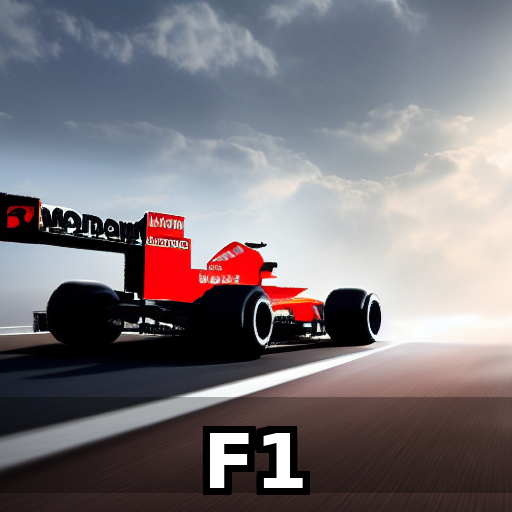

✅ Test function ready! Use: quick_generate('prompt', 'caption')


In [ ]:
# Quick test generation without UI
def quick_generate(prompt_text, caption_text, style="vibrant"):
    """Generate thumbnail without Streamlit"""
    print("🚀 Loading model...")
    pipe, device = load_model()

    print("🎨 Generating image...")
    base_img = generate_image(pipe, device, prompt_text, style, 512, 512, 25)

    print("✍️ Adding caption...")
    final_img = add_caption(base_img, caption_text)

    print("💾 Saving...")
    final_img.save("my_thumbnail.png", quality=95)

    print("✅ Done! Saved as my_thumbnail.png")
    return final_img

# Example usage:
result = quick_generate("f1 car on highway ", "f1 ", "epic")
display(result)

print("✅ Test function ready! Use: quick_generate('prompt', 'caption')")


In [ ]:
!python thumbnail_app.py

2025-11-06 07:24:00.807956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762413840.840096    1040 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762413840.849945    1040 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762413840.872802    1040 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762413840.872838    1040 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762413840.872846    1040 computation_placer.cc:177] computation placer alr